# Black Scholes Model

The Black-Scholes Model was developed by professor Fisher Black, Myron Scholes, and Robert Merton. The model is used to value option contracts. The model makes the following assumptions: 
- Lognormal distribution for the stock price
- There are no transaction costs or taxes
- There is no cash flow from the underlying asset during the time to maturity of the option
- There are no arbitrage opportunities
- Investors can borrow or lend at the risk-free rate 
- The risk-free rate is constant
- The model is based on European-style options


The key concept from the mathematical model is that the option and the stock price depend on the same underlying source of uncertainty. This uncertainty could be eliminated by constructing a portfolio with the stock and the option. This portfolio should be instantaneously riskless and earn the risk-free rate. The portfolio will require continuous rebalancing.

The mathematical formula to calculate the call price of a European option is:

\begin{equation*}
C = S_t N \left(d1 \right) - K e^{-rt} N \left(d2 \right)
\end{equation*}

__Where:__

\begin{equation*}
d1 = \frac{ \ln{ \frac{S_t}{K} + \left(r + \frac{\sigma_u^2}{2} \right) t} }{\sigma_s \sqrt{t}}
\end{equation*}

and:

\begin{equation*}
d2 = d1 -  \sigma_s \sqrt{t}
\end{equation*}


__Where:__

\begin{alignat*}{1}
&C \quad & = \quad & \text{Call option price} \\
&S \quad & = \quad & \text{Current stock (or other underlying) price} \\
&K \quad & = \quad & \text{Strike price} \\
&r \quad & = \quad & \text{Risk-free interest rate} \\
&t \quad & = \quad & \text{time to maturity} \\
&N \quad & = \quad & \text{A normal distribution}
\end{alignat*}

In this notebook, I will develop a process to calculate the call price of any option given all the parameters required in the Black-Scholes model. To do that, I will use Python, specifically Yfinance and Quandl, libraries to obtain the required data.

First, let's import the necessary libraries to make the analysis.

__Note:__ Some libraries might not be pre-installed so the reader will need to uncomment the line code to install them. 

In [1]:
#pip install stockquotes
#pip install Quandl

import math
import scipy.stats as st
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import stockquotes
import quandl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from BlackScholesMerton import BlackScholesModel
import os
from scipy.optimize import minimize

%matplotlib inline

I will use the Quandl library to obtain information about the risk-free rate. To use Quandl, you will need to set up an account and get an API key. The code to call Quandl API is <code>quandl.ApiConfig.api_key = 'YOUR KEY GOES HERE'</code>

In [2]:
quandl.ApiConfig.api_key = os.environ.get('QUANDL_KEY')

From the YFinance library, I will get the historical information of the S&P500.

In [3]:
GSPC = yf.Ticker('^GSPC')

This library also allows getting the expiration dates for the options.

In [4]:
expirations = GSPC.options
expirations

('2020-12-17', '2021-12-16')

Based on the expirations, I can get the option chain with the information required to calculate the option price using the Black-Scholes model. Let's have a look at the information available for the option chain on the S&P 500 with expiration on December 17, 2020.

In [5]:
GSPC_opts = GSPC.option_chain(expirations[0])
GSPC_opts

Options(calls=        contractSymbol       lastTradeDate  strike  lastPrice     bid     ask  \
0   SPX201218C00100000 2020-08-05 07:02:25   100.0    3195.90     0.0     0.0   
1   SPX201218C00200000 2020-07-23 18:39:30   200.0    3006.29     0.0     0.0   
2   SPX201218C00300000 2020-07-10 00:10:28   300.0    2738.00  2998.0  3003.5   
3   SPX201218C00400000 2020-07-10 00:10:30   400.0    2638.40  2898.2  2903.7   
4   SPX201218C00500000 2020-07-27 12:00:10   500.0    2707.70     0.0     0.0   
..                 ...                 ...     ...        ...     ...     ...   
89  SPX201218C03800000 2020-08-06 20:03:47  3800.0      19.09     0.0     0.0   
90  SPX201218C03900000 2020-08-06 20:03:47  3900.0      11.14     0.0     0.0   
91  SPX201218C04000000 2020-08-06 20:03:47  4000.0       6.55     0.0     0.0   
92  SPX201218C04100000 2020-08-06 18:22:36  4100.0       3.69     0.0     0.0   
93  SPX201218C04200000 2020-08-06 17:59:44  4200.0       2.18     0.0     0.0   

    change  p

This analysis will focus only on calculating the call price; however, once a put price formula is defined the reader can easily run the code with all the variables already defined in this notebook. Let's have a look at the DataFrame generated from YFinance.

In [6]:
GSPC_calls = GSPC_opts.calls
GSPC_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPX201218C00100000,2020-08-05 07:02:25,100.0,3195.90,0.0,0.0,0.0,0.0,1,3269,0.000010,True,REGULAR,USD
1,SPX201218C00200000,2020-07-23 18:39:30,200.0,3006.29,0.0,0.0,0.0,0.0,20,3144,0.000010,True,REGULAR,USD
2,SPX201218C00300000,2020-07-10 00:10:28,300.0,2738.00,2998.0,3003.5,0.0,0.0,8,86,0.000010,True,REGULAR,USD
3,SPX201218C00400000,2020-07-10 00:10:30,400.0,2638.40,2898.2,2903.7,0.0,0.0,6,16,0.000010,True,REGULAR,USD
4,SPX201218C00500000,2020-07-27 12:00:10,500.0,2707.70,0.0,0.0,0.0,0.0,1,58,0.000010,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,SPX201218C03800000,2020-08-06 20:03:47,3800.0,19.09,0.0,0.0,0.0,0.0,26,13891,0.031260,False,REGULAR,USD
90,SPX201218C03900000,2020-08-06 20:03:47,3900.0,11.14,0.0,0.0,0.0,0.0,84,7533,0.062509,False,REGULAR,USD
91,SPX201218C04000000,2020-08-06 20:03:47,4000.0,6.55,0.0,0.0,0.0,0.0,430,11484,0.062509,False,REGULAR,USD
92,SPX201218C04100000,2020-08-06 18:22:36,4100.0,3.69,0.0,0.0,0.0,0.0,115,2119,0.062509,False,REGULAR,USD


From this dataFrame, I need the information related to the strike price and the implied volatility.

We can save the strike price in a dictionary where the keys will be the different expiration dates and the values will be an array with all the strike prices available on the specific expiration date. 

In [7]:
K = {name: pd.DataFrame()for name in expirations}

for i, a in enumerate(expirations):
    GSPC_opts = GSPC.option_chain(expirations[i])
    GSPC_calls = GSPC_opts.calls
    K[a] = GSPC_calls['strike']

Similarly, I can get a dictionary with information related to the implied volatility. Once again, the keys of the dictionary will be the different expiration dates and the values of the dictionary will be an array with the implied volatility corresponding to a determined strike price.

In [8]:
sigma = {name: pd.DataFrame() for name in expirations}

for i, a in enumerate(expirations):
    GSPC_opts = GSPC.option_chain(expirations[i])
    GSPC_calls = GSPC_opts.calls
    sigma[a] = GSPC_calls['impliedVolatility']

With the same logic used before, I can get the time to maturity for each expiration date. I will define a dictionary where the keys are the different expiration dates available, and the values of the dictionary are the difference between the current date and the expiration date. However, in this case, values are not an array of data, instead, the values are a scalar.

In [9]:
t = {name: pd.DataFrame() for name in expirations}

for i, a in enumerate(expirations):
    expiration_date = datetime.strptime(expirations[i],"%Y-%m-%d") 
    today = datetime.now()
    t[a] = (expiration_date - today).days/365

Using the Quandl library, I can get access to the daily Treasury Yield Curve and saved it in a variable called <code>yield_curve</code>. To get the yield curve, I used the get module as follows: <code>quandl.get("USTREASURY/YIELD", authtoken="YOUR TOKEN GOES HERE")</code>

In [10]:
yield_curve = quandl.get("USTREASURY/YIELD", authtoken = os.environ.get('QUANDL_KEY'))
yield_curve

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,0.09,0.09,0.09,0.10,0.11,0.11,0.11,0.21,0.39,0.55,0.98,1.20
2020-08-03,0.09,0.09,0.10,0.11,0.12,0.11,0.13,0.22,0.40,0.56,1.01,1.23
2020-08-04,0.09,0.09,0.09,0.11,0.14,0.11,0.10,0.19,0.36,0.52,0.96,1.19


Now, I will define a function that allows me to calculate the time to maturity of the option based on the expiration date. The next step will be to match this time to maturity with the most appropriate treasury yield.

To achieve this matching task, I will define a function that browses through the list of available treasury maturities and matches the time to maturity of the option with the corresponding yield of the closest greater treasury maturity.

In [11]:
def TTM(exp_date,today):
    time_to_maturity = (exp_date - today).days
    return time_to_maturity

def rf(exp_date,today):
    num_days = [30,60,90,180,365,730,1095,1825,2555,3650,7300,10950]
    rf_ttm = list(yield_curve.columns)
    risk_free_L = []
    if round(TTM(exp_date,today)) < 0:
        return "Expire date must be greater than today"
    elif round(TTM(exp_date,today)) > num_days[-1]: 
        return yield_curve[rf_ttm[-1]][-1]/100
    else:
        for b, f in zip(num_days, rf_ttm):
                if round(TTM(expiration_date,today)) < b:
                    risk_free_L.append(yield_curve[f][-1]/100)
        return risk_free_L[0]

With this last function defined, I can create a dictionary with the different risk-free rates relevant for each expiration. Again, the keys of the dictionary will be the expirations of the option and the values will be a scalar with the corresponding risk-free rate.

In [12]:
rf_rate = {name: pd.DataFrame() for name in expirations}

for i, a in enumerate(expirations):
    expiration_date = datetime.strptime(expirations[i],"%Y-%m-%d") 
    today = datetime.now()
    rf_rate[a] = rf(expiration_date,today)

The last variable needed to calculate the price of the call option is the current price of the security. This can be obtained from the stockquotes library through the <code>Stock</code> module.

In [13]:
SP500 = stockquotes.Stock("^GSPC")
S = SP500.current_price

Now, let's develop the Black-Scholes model. I will define the model with 3 different functions; the advantage of this is that these functions could potentially  be used to create a Black-Scholes Class in Python for future development projects.

The first function will calculate the expected value of the stock if the option is exercised using risk-adjusted probabilities. This is the equivalent of the term $\begin{equation*}N \left(d1 \right)\end{equation*}$. The function will return a tuple containing $\begin{equation*}d1 \end{equation*}$ and $\begin{equation*}N \left(d1 \right)\end{equation*}$.

In [14]:
def Norm_d1(S, K, r, t, sigma):
    d1 = (np.log(S/K)+(r+((np.power(sigma,2)/2))*t))/(sigma*math.sqrt(t))
    N_d1 = st.norm.cdf(d1)
    return (d1, N_d1)

The next function that I will define is the probability of the function to be exercised based on risk-adjusted probabilities. This is equivalent to the term $\begin{equation*}N \left(d2 \right)\end{equation*}$.

In [15]:
def Norm_d2(d1, sigma, t):
    d2 = d1 - sigma*math.sqrt(t)
    N_d2 = st.norm.cdf(d2)
    return N_d2

Lastly, I will define the function that will calculate the call price taking an input all the variables required in the model and using the previous two functions.

In [16]:
def Call_price(S, K, r, t, sigma):
    d1, N_d1 = Norm_d1(S, K, r, t, sigma)
    N_d2 = Norm_d2(d1, sigma, t)
    C = S*N_d1-K*math.exp(-r*t)*N_d2
    return C

With the call price function define, I can create a dictionary that saves the array of call prices for different expiration dates. 

In [17]:
C = {name: pd.DataFrame() for name in expirations}

for i, a in enumerate(expirations):
    C[a] = Call_price(S, K[a], rf_rate[a], t[a], sigma[a])

Let's visualize the results. The following graph will compare, for the two expirations available, the call price for different strike prices calculated using the Black-Scholes model and the actual price taken from the YFinance library. 

In [18]:
def callP_plot(n_rows, n_col, figure_size, expir_dates, subtitle=None):
    
    if not isinstance(figure_size, (list,tuple)):
        print("Figure size has to be Tuple or List with the width and the height")
        return

    fig,axs = plt.subplots(n_rows,n_col,figsize=figure_size)

    if subtitle == None:
        name = GSPC.info['shortName']
        fig.suptitle(f'{name} Call Value vs. Strike Price',fontsize=18,fontweight='bold')
    else:
        fig.suptitle(subtitle,fontsize=18,fontweight='bold')
    i, j = 0, 0
    for n in (0,len(expir_dates)-1):
        
        if n_rows == 1:
            ax = axs[j]
        elif n_col == 1:
            ax = axs[i]
        else:
            ax = axs[i,j]

        ax.plot(K[expir_dates[n]], 
                    C[expir_dates[n]],
                    'tab:red',
                    linewidth=4.0,
                    label='BSM model') #Plots the first expiration based on BSM model
        ax.plot(K[expir_dates[n]], 
                    GSPC.option_chain(expir_dates[n]).calls['lastPrice'],
                    'tab:cyan',
                    linewidth=1.0, 
                    label='Market price') #Plots the first expiration based on actual market price
        ax.legend(labelspacing=2,borderpad=1.25,fontsize=10) #Set legend 
        ax.set_xlim(xmin=0.0) #To start the graph on (0,0)
        ax.set_ylim(ymin=0.0)
        ax.set_xlabel("Strike Price",fontsize=14) #Set X-axis label
        ax.set_ylabel("Call Price",fontsize=14) #Set Y-axis label
        ax.set_title(f"Expiration: {datetime.strptime(expir_dates[n],'%Y-%m-%d').strftime('%b %d, %Y')}",
                         fontsize=14) #Subtitle on the first figure
        ax.spines['right'].set_visible(False) #Remove right border on the first subplot
        ax.spines['top'].set_visible(False)  #Remove top border on the first subplot
        
        if i + 1 > n_rows - 1:
            j = j + 1
            i = 0
        else:
            i += 1
    plt.show()

    plt.close()    

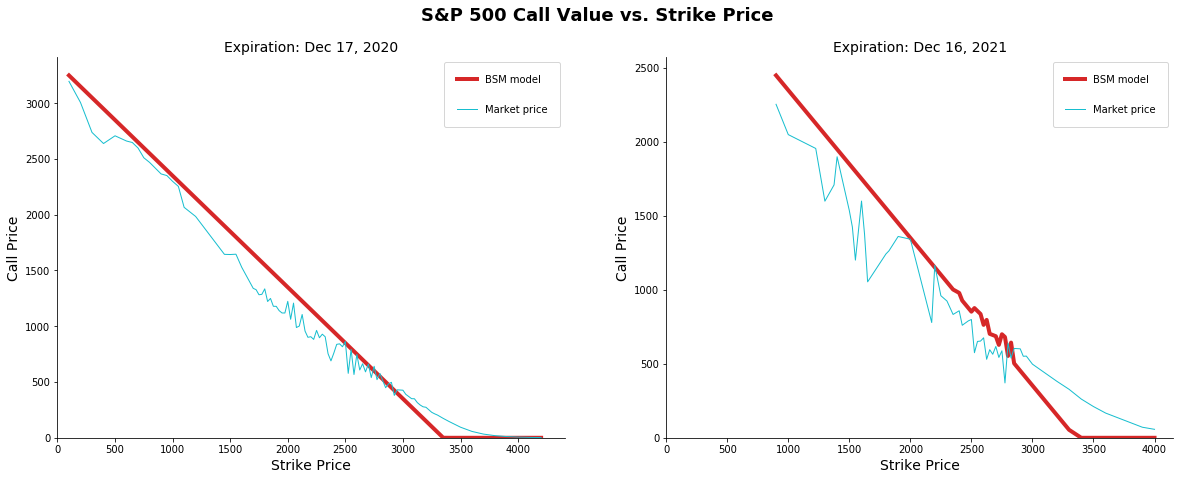

In [19]:
callP_plot(1,2,(20,7),expir_dates = expirations)

The difference between the Black-Scholes model and the actual price could be explained by lack of liquidity, especially in options with low strike price, and/or differences in the implied volatility. 

__References:__<p>&nbsp;</p> 
- Investopedia (2020). Black Scholes Model https://www.investopedia.com/terms/b/blackscholes.asp
- John C. Hull (2016). Fundamentals of Futures and Options Markets, 9th Ed, Ch 13

# Implied Volatility

In [20]:
expiration_date = datetime.strptime(expirations[1],"%Y-%m-%d") 
td = datetime.now()

In [57]:
GSPC_opts = GSPC.option_chain(expirations[1])

GSPC_calls = GSPC_opts.calls

expiration_date = datetime.strptime(expirations[1],"%Y-%m-%d")
td = datetime.now()
strike = GSPC_calls['strike'][1]

SP500 = stockquotes.Stock("^GSPC")
stock_price = SP500.current_price

Call_premium = GSPC_calls['lastPrice'][1]

In [41]:
BSM = BlackScholesModel(expiration_date,td,stock_price,strike,premium=Call_premium)


In [42]:
BSM.maturity()

1.356164383561644

In [43]:
BSM.difference(4)

52832.79107930968

In [44]:
x0 = [1]
minimize(BSM.difference, x0)

      fun: 4.3483695133155356e-12
 hess_inv: array([[6.38297064e-06]])
      jac: array([-1.40002389e-09])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([2.44284177])

In [32]:
# x0 = [1]
# minimize(BSM.difference(1),x0)

In [51]:
price = 3271.12
strike = 1000
Risk_free = 0.0011
time_to_maturity = 1.356164383561644
Call_premium = 3006.29

In [53]:
def Norm_d1(S, K, r, t, sigma):
    d1 = (np.log(S/K)+(r+((np.power(sigma,2)/2))*t))/(sigma*math.sqrt(t))
    N_d1 = st.norm.cdf(d1)
    return (d1, N_d1)

def Norm_d2(d1, sigma, t):
    d2 = d1 - sigma*math.sqrt(t)
    N_d2 = st.norm.cdf(d2)
    return N_d2

def Call_price(S, K, r, t, sigma):
    d1, N_d1 = Norm_d1(S, K, r, t, sigma)
    N_d2 = Norm_d2(d1, sigma, t)
    C = S*N_d1-K*math.exp(-r*t)*N_d2
    return C

def difference(sigma):
    d1, N_d1 = Norm_d1(price, strike, Risk_free, time_to_maturity, sigma)
    N_d2 = Norm_d2(d1, sigma, time_to_maturity)
    C = price*N_d1-strike*math.exp(-Risk_free*time_to_maturity)*N_d2
    return (Call_premium - C)**2

In [54]:
x0 = [2]
minimize(difference, x0)

      fun: 4.00322296848927e-12
 hess_inv: array([[6.38299023e-06]])
      jac: array([4.72812352e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 246
      nit: 8
     njev: 78
   status: 2
  success: False
        x: array([2.44284177])